In [114]:
import logging
from argparse import ArgumentParser
import torch
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader
from tqdm import trange
import numpy as np
from experiments.data import INRDataset
from collections import defaultdict

In [115]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.enabled = False

In [116]:
#Loading inr data we created while mnist training
import os
current_working_directory = os.getcwd()
print(current_working_directory)
path = current_working_directory + "/notebooks/dataset/mnist_splits.json"
statistics_path = current_working_directory + "/notebooks/dataset/statistics.pth"
normalize = True
augmentation = True

batch_size = 64
num_workers = 1

/work/talisman/sgupta/DWSNets/equivariant-diffusion


In [117]:
train_set = INRDataset(
        path=path,
        split="train",
        normalize=normalize,
        augmentation=augmentation,
        statistics_path=statistics_path,
    )

val_set = INRDataset(
    path=path,
    split="val",
    normalize=normalize,
    statistics_path=statistics_path,
)

test_set = INRDataset(
    path=path,
    split="test",
    normalize=normalize,
    statistics_path=statistics_path,
)

train_loader = torch.utils.data.DataLoader(
        dataset=train_set,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
val_loader = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
)

print(
    f"train size {len(train_set)}, "
    f"val size {len(val_set)}, "
    f"test size {len(test_set)}"
)

train size 55000, val size 5000, test size 10000


/work/talisman/sgupta/DWSNets/equivariant-diffusion/experiments/data.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.stats = torch.load(statistics_path, map_locati

In [118]:
point = train_set.__getitem__(4)
weight_shapes = tuple(w.shape for w in point.weights)
bias_shapes = tuple(b.shape for b in point.biases)
print(weight_shapes,bias_shapes)

(torch.Size([2, 32, 1]), torch.Size([32, 32, 1]), torch.Size([32, 1, 1])) (torch.Size([32, 1]), torch.Size([32, 1]), torch.Size([1, 1]))


In [119]:
def convert_to_tensor_format(point):
    """Convert tuple-based weights and biases to tensor-based format"""
    weights_tuple, biases_tuple = point.weights, point.biases
    permutations = defaultdict(list)
    for i,(layer_weights,layer_biases) in enumerate(zip(weights_tuple,biases_tuple)): 
        permutations["layer_"+str(i+1)+"_weights"] = np.array(layer_weights)
        permutations["layer_"+str(i+1)+"_biases"] = np.array(layer_biases)
    return permutations

Just Permuting Hidden layers

In [120]:
import numpy.ma as ma
from scipy.optimize import linear_sum_assignment

def apply_permutation_hidden(params_b, optimal_perm):
    permuted_params_b = {}

    for layer_name, param in params_b.items():
        if layer_name in optimal_perm:
            perm = optimal_perm[layer_name]
            permuted_params_b[layer_name] = np.take(param, perm, axis=0)
            
            if "weights" in layer_name:
                permuted_params_b[layer_name] = np.take(permuted_params_b[layer_name], perm, axis=1)
        else:
            permuted_params_b[layer_name] = param

    return permuted_params_b

def weight_matching_just_hidden_layers(rng, params_a, params_b, max_iter=100, init_perm=None, silent=False):
    """Find a permutation of `params_b` to make them match `params_a` for hidden layer only."""

    perm_layers = ['layer_2_weights', 'layer_2_biases']
    
    # Get the sizes of these layers for permutation
    perm_sizes = {layer: params_a[layer].shape[0] for layer in perm_layers}  # Assuming square layers
    
    # Initialize permutations
    perm = {p: np.arange(n) for p, n in perm_sizes.items()} if init_perm is None else init_perm

    for iteration in range(max_iter):
        progress = False
        for p in perm_layers:
            n = perm_sizes[p]
            A = np.zeros((n, n))
            
            # Get weights/biases for current layer in both params_a and params_b
            w_a = params_a[p]
            w_b = np.take(params_b[p], perm[p], axis=0)  # Apply current permutation
            
            # Reshape and compute similarity matrix
            w_a_flat = w_a.reshape((n, -1))
            w_b_flat = w_b.reshape((n, -1))
            A = w_a_flat @ w_b_flat.T
            
            # Solve the assignment problem to find the best permutation
            ri, ci = linear_sum_assignment(A, maximize=True)
            
            # Compute old and new alignment scores
            oldL = np.vdot(A, np.eye(n)[perm[p]])
            newL = np.vdot(A, np.eye(n)[ci, :])
            if not silent:
                print(f"Iteration {iteration} - Layer {p}: Score improvement {newL - oldL}")
            
            # Update permutation if there's an improvement
            progress = progress or newL > oldL + 1e-12
            perm[p] = np.array(ci)

        # Stop if no improvement
        if not progress:
            break

    return perm


In [ ]:
PermutingEverything

In [148]:
from scipy.optimize import linear_sum_assignment
import numpy as np

# Define which layers (weights and biases) are permutable and their permutation axis
perm_layers = {
    "layer_1_weights": 0,  # Permute along the second axis (columns)
    "layer_2_weights": 0,  # Permute along the first axis (rows)
    "layer_3_weights": 0,  # Permute along the first axis (rows)
    "layer_1_biases": 0,   # Permute along the first axis (rows)
    "layer_2_biases": 0,   # Permute along the second axis (columns)
    "layer_3_biases": 0,  # Permute along the second axis (columns)
    "layer_1_weights": 1,  # Permute along the second axis (columns)
    "layer_2_weights": 1,  # Permute along the first axis (rows)
    "layer_3_weights": 1,  # Permute along the first axis (rows)
    "layer_1_biases": 1,   # Permute along the first axis (rows)
    "layer_2_biases": 1,   # Permute along the second axis (columns)
    "layer_3_biases": 1, 
}

def weight_matching(rng, params_a, params_b, max_iter=100, init_perm=None, silent=False):
    """Find a permutation of `params_b` to make it match `params_a`."""
    
    # Initialize permutation sizes based on params_a
    perm_sizes = {layer: params_a[layer].shape[axis] for layer, axis in perm_layers.items()}

    # Initialize the permutation dictionary
    perm = {p: np.arange(n) for p, n in perm_sizes.items()} if init_perm is None else init_perm
    perm_names = list(perm.keys())

    for iteration in range(max_iter):
        progress = False
        # Iterate through each layer in a random order to update its permutation
        for p_ix in rng.permutation(len(perm_names)):
            p = perm_names[p_ix]
            n = perm_sizes[p]
            A = np.zeros((n, n))
            
            # Get axis along which permutation is applied
            perm_axis = perm_layers[p]

            # Compute the assignment matrix for this layer
            w_a = params_a[p]
            w_b = get_permuted_param(perm, p, params_b)  # Pass perm_layers here
            
            # Reshape to (n, -1) for matrix comparison
            w_a_flat = np.moveaxis(w_a, perm_axis, 0).reshape((n, -1))
            w_b_flat = np.moveaxis(w_b, perm_axis, 0).reshape((n, -1))
            A += w_a_flat @ w_b_flat.T

            # Find optimal row permutation
            ri, ci = linear_sum_assignment(A, maximize=True)
            assert (ri == np.arange(len(ri))).all()

            # Calculate old and new objective values
            oldL = np.vdot(A, np.eye(n)[perm[p]])
            newL = np.vdot(A, np.eye(n)[ci, :])
            if not silent: print(f"{iteration}/{p}: {newL - oldL}")
            progress = progress or newL > oldL + 1e-12

            # Update the permutation for this layer
            perm[p] = np.array(ci)

        # Break if no progress is made
        if not progress:
            break

    return perm

# Define helper function to apply permutation
def get_permuted_param(perm, layer, params_b):
    """Apply permutation to the layer in params_b."""
    permuted_param = params_b[layer].copy()
    perm_axis = perm_layers[layer]
    permuted_param = np.take(permuted_param, perm[layer], axis=perm_axis)
    return permuted_param

# Apply permutations to all layers (including biases) in the dictionary
def apply_permutations(params_b, perm):
    """Apply the layer permutations to params_b (weights and biases)."""
    permuted_params = {}
    for layer, perm_indices in perm.items():
        perm_axis = perm_layers[layer]
        # Apply permutation to the specific layer using the precomputed permutation indices
        permuted_params[layer] = np.take(params_b[layer], perm_indices, axis=perm_axis)
    return permuted_params

In [152]:
point1 = train_set.__getitem__(2)
point_a = convert_to_tensor_format(point1)
print(point1.label)

2


/work/talisman/sgupta/DWSNets/equivariant-diffusion/experiments/data.py:210: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=lambda 

In [153]:
point2 = train_set.__getitem__(8)
point_b = convert_to_tensor_format(point2)
print(point2.label)

2


In [154]:
rng = np.random.default_rng(seed=42) 
perm = weight_matching(rng, point_a, point_b)
permuted_params_b = apply_permutations(point_b, perm)

0/layer_1_biases: 0.0
0/layer_3_weights: 0.0
0/layer_3_biases: 0.0
0/layer_2_biases: 0.0
0/layer_2_weights: 261.61632539331913
0/layer_1_weights: 59.04834580793977
1/layer_3_weights: 0.0
1/layer_2_biases: 0.0
1/layer_1_weights: 59.40569671057165
1/layer_2_weights: 246.33331902325153
1/layer_1_biases: 0.0
1/layer_3_biases: 0.0
2/layer_3_biases: 0.0
2/layer_2_biases: 0.0
2/layer_3_weights: 0.0
2/layer_1_biases: 0.0
2/layer_1_weights: 59.04834580793977
2/layer_2_weights: 261.61632539331913
3/layer_2_biases: 0.0
3/layer_1_weights: 59.40569671057165
3/layer_3_weights: 0.0
3/layer_1_biases: 0.0
3/layer_3_biases: 0.0
3/layer_2_weights: 246.33331902325153
4/layer_3_biases: 0.0
4/layer_1_weights: 59.04834580793977
4/layer_2_biases: 0.0
4/layer_3_weights: 0.0
4/layer_1_biases: 0.0
4/layer_2_weights: 261.61632539331913
5/layer_2_weights: 246.33331902325153
5/layer_1_weights: 59.40569671057165
5/layer_3_biases: 0.0
5/layer_2_biases: 0.0
5/layer_1_biases: 0.0
5/layer_3_weights: 0.0
6/layer_3_biases

In [155]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def flatten_and_concatenate(params):
    """Flatten the weights and biases for each layer and concatenate them."""
    flattened_params = []
    
    for layer in list(params.keys()):
        if 'weights' in layer:
            # Flatten the weights
            layer_weights = np.array(params[layer]).flatten()
            flattened_params.append(layer_weights)
        elif 'biases' in layer:
            # Flatten the biases
            layer_biases = np.array(params[layer]).flatten()
            flattened_params.append(layer_biases)
    
    # Return a single concatenated vector for all layers in the dictionary
    return np.concatenate(flattened_params)

def plot_tsne(point_a, point_b, permuted_params_b):
    """Plot t-SNE of weights and biases from point_a, point_b, and permuted_params_b."""
    
    # Flatten and concatenate the weights and biases for point_a, point_b, and permuted_params_b
    flattened_a = flatten_and_concatenate(point_a)
    flattened_b = flatten_and_concatenate(point_b)
    flattened_permuted_b = flatten_and_concatenate(permuted_params_b)
    
    # Combine all flattened parameters for t-SNE
    all_params = np.vstack([flattened_a, flattened_b, flattened_permuted_b])
    
    # Perform t-SNE to reduce the dimensions to 2D
    tsne = TSNE(n_components=2, random_state=42, perplexity=2)
    tsne_results = tsne.fit_transform(all_params)
    
    # Plot the t-SNE results
    plt.figure(figsize=(10, 6))
    
    # Plot points from point_a, point_b, and permuted_params_b with different colors
    plt.scatter(tsne_results[0, 0], tsne_results[0, 1], label='point_a', color='blue', s=100)
    plt.scatter(tsne_results[1, 0], tsne_results[1, 1], label='point_b', color='red', s=100)
    plt.scatter(tsne_results[2, 0], tsne_results[2, 1], label='permuted_params_b', color='green', s=100)
    
    # Add titles and labels
    plt.title("t-SNE visualization of weights and biases")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend()
    
    # Show plot
    plt.show()

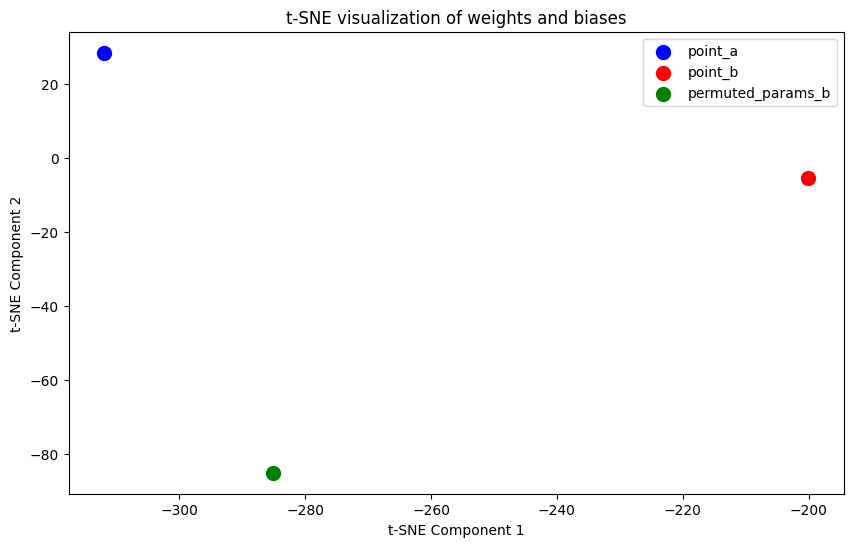

In [156]:
plot_tsne(point_a, point_b, permuted_params_b)